# Meyr-Oerder Timing Algorithm

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pprint
sys.path.append('../library')
import numpy as np
import matplotlib.pyplot as plt
from fir_filter import FIRFilter
from generic_modem import GenericModem
from timing_sync_polyphase import TimingSyncPolyphase
from utilities import phase_shift


$$ \hat{\tau} = \frac{T}{2 \pi} arg \left\{ \sum_{k=0}^{N L_0 -1} {| x(k T s) |}^2 e^{-2 \pi i k/N} \right\}  $$

where: $\hat{\tau}$ is the timing estimate

$T$ is the symbol period

$N$ is the overs-sampling ratio

$L_0$ is the number of symbols used for estimation

$T_s$ is the sampling time


The above equation shows a squaring operation which is required for an order 2 modulation (ie. BPSK).
The simulations below use an order 4 modulation (QPSK) therefore a fourth power is required to remove the modulation from the received signal.

In [40]:
def meyr_oerder(signal, L, N=4):

    summation = 0
    for k, samp in enumerate(signal):
        
        squared = samp**4
        
        summation += squared * np.exp(-1j*2*np.pi*k/N)
    
    return np.angle(summation)/(2*np.pi)

#### Find the Sensitivity

Pass a phase shifted signal through the detector to find the sensitivty

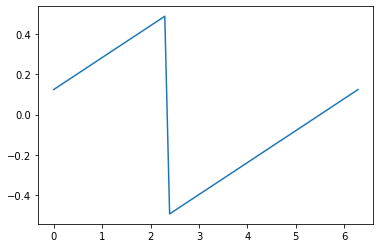

In [41]:
# create test data
data_length = 64*4*8*2
data = [np.random.randint(2) for _ in range(data_length)]
modem_bpsk_obj = GenericModem(  modulation_type = ["129", "QPSK 2/9"],
                                samples_per_symbol = 4,
                                pulse_factor = 0.5,
                                pulse_length = 33,
                                filename = "../library/DVB-S2X_constellations.json")
tx = modem_bpsk_obj.modulate(data)

# measure sensitivity
N = 4
sensitivity = []
phase     = np.linspace(0,N,64)
phase_rad = np.linspace(0,2*np.pi,64)
for phase_i in phase:
    
    signal = phase_shift(tx, phase_i)
    sensitivity.append(meyr_oerder(signal, L=data_length, N=N))

plt.plot(phase_rad, sensitivity)
plt.show()

#### Find the Sensitivity in Noise

Perform the operation above again but this time in the presence of noise to examine the behaviour in non-ideal scenarios

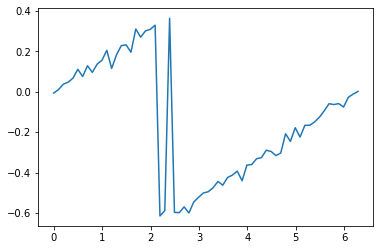

In [36]:
# measure sensitivity
N = 4
sensitivity = []
phase     = np.linspace(0,N,64)
phase_rad = np.linspace(0,2*np.pi,64)
for phase_i in phase:
    
    signal = phase_shift(tx, phase_i) + 0.5*(np.random.randn()+1j*np.random.randn())
    sensitivity.append(meyr_oerder(signal, L=data_length, N=N))

plt.plot(phase_rad, sensitivity)
plt.show()